In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import time
import concurrent
from scipy.optimize import rosen

In [2]:
from pyBO import pyBO
from pyBO import Auto
from pyBO.model import GaussianProcess
from pyBO.covfunc import squaredExponential, matern52, matern32
from pyBO.util import proximal_ordered_init_sampler

In [3]:
# budget = 32
n_init = 2
ndim = 2
bounds = np.array(((-2,2),)*ndim)

evaluation_wait_time = 2

In [4]:
def np_str(x,precision=3):
    return np.array2string(x, precision=precision)

### cost func

In [5]:
def bilog_inv_rosen(x):
    y = -rosen(x)
    return np.sign(y)*np.log(1+np.abs(y))

In [6]:
def bilog_inv_rosen_vec(x):
    y = np.zeros(len(x))
    for i in range(len(x)):
        y[i] = bilog_inv_rosen(x[i,:])
    return y

In [7]:
def delayed_bilog_inv_rosen(x):
    time.sleep(evaluation_wait_time)
    return bilog_inv_rosen(x)

### prior mean model

In [8]:
def quadratic(x):
    return np.sum(x**2,axis=1).reshape(-1,1)

In [9]:
prior_mean_model = quadratic

# asynchronous BO

##### init 

In [10]:
x0 = np.random.rand(1,ndim)*(bounds[:,1]-bounds[:,0])+bounds[:,0]  # current set point
y0 = bilog_inv_rosen_vec(x0)

##### assuming decision parameter polarity change is costly

In [11]:
if n_init>1:
    train_x = proximal_ordered_init_sampler(n_init-1,bounds=bounds,x0=x0,ramping_rate=np.ones(ndim),polarity_change_time=10,method='sobol',seed=None)
    train_y = bilog_inv_rosen_vec(train_x)
    train_x = np.concatenate((x0,train_x),axis=0)
    train_y = np.concatenate((y0,train_y),axis=0)
else:
    train_x = x0
    train_y = y0

(-2.0, 2.0)

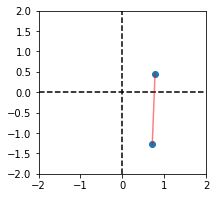

In [12]:
# check initial candidates are ordered to minimize ramping time including polarity change time
fig,ax=plt.subplots(figsize=(3,3))
ax.plot(train_x[:,0],train_x[:,1],alpha=0.5,c='r')
ax.scatter(train_x[:,0],train_x[:,1])
ax.hlines(0,bounds[0,0],bounds[0,1],ls='--',color='k')
ax.vlines(0,bounds[1,0],bounds[1,1],ls='--',color='k')
ax.set_xlim(bounds[0,0],bounds[0,1])
ax.set_ylim(bounds[1,0],bounds[1,1])

In [13]:
model = GaussianProcess(matern52())
bo = pyBO(
            model = model,
            x = train_x, 
            y = train_y,
            bounds = bounds,
            acquisition_func = 'EI',
            prior_mean_model = prior_mean_model
         )

[████████████████████████████████████████] 100%/100%



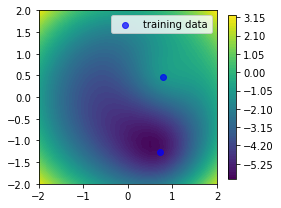

In [14]:
# plot initialized model with initial data. 
fig,ax = plt.subplots(figsize=(4,3))
# project maximum along the dimensions orthogonal to the porjected dimension
# projection dimensions are dim_xaxis=0,dim_yaxis=1 by default
# the goal of BO is maximization. 
bo.plot_model_2D_projection(project_maximum=True,fig=fig,ax=ax)
fig.tight_layout()

[████████████████████████████████████████] 100%/100%



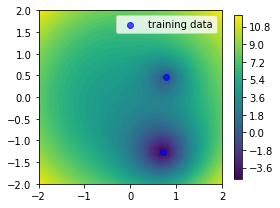

In [15]:
fig,ax = plt.subplots(figsize=(4,3))
bo.plot_acquisition_2D_projection(project_maximum=True,fig=fig,ax=ax)
fig.tight_layout()

In [16]:
##### remind bounds
bounds

array([[-2,  2],
       [-2,  2]])

###### test favor center

In [17]:
#default querry acquisition function is 'EI'
x1 = bo.query_candidates(bounds = bounds,
                         X_favor = np.zeros(ndim),
                         L_favor = 0.2,
                         C_favor = 100,
                         )
bo.remove_qeury_record()  # remove this test query record
x1  # resulting candidate is near the center

array([[-1.28378086e-05,  8.02561498e-05]])

###### test penalize center

In [18]:
x1 = bo.query_candidates(bounds = bounds,
                         X_penal = np.zeros(ndim),
                         L_penal = 1.0,
                         C_penal = 100)
bo.remove_qeury_record() 
x1 # resulting candidate is far from the center

array([[2., 2.]])

###### 1st query 

In [19]:
# w/o penalization  
# defult bounds is same as the most recent one
x1 = bo.query_candidates( X_current = train_x[-1:,:],  # this is used to impose polarity change penality
                          polarity_penalty = 0.5,
                          X_penal = Auto,  # this is used to penalize currently set point. L_penal, C_penal will be automatically selected based on data
                          X_favor = None
                         )

executor = concurrent.futures.ThreadPoolExecutor(max_workers=1)
y1_future = executor.submit(delayed_bilog_inv_rosen,x1.flatten())  # asynchronous parallel objective evaluation

[████████████████████████████████████████] 100%/100%



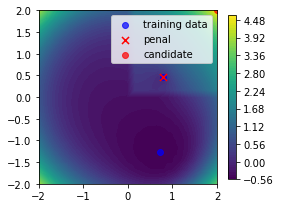

In [20]:
# check acuquisition functions
fig,ax = plt.subplots(figsize=(4,3))
bo.plot_acquisition_2D_projection(project_maximum=True,fig=fig,ax=ax)
fig.tight_layout()
ax.legend()

###### 2nd query while evaluating 1st candidate